In [1]:
########################################################################################################################
#                                                          IMPORT                                                      #
########################################################################################################################
import torch
import sys
import os
import json
import numpy as np
sys.path.append('..')

from singleVis.SingleVisualizationModel import VisModel

from singleVis.data import NormalDataProvider

from singleVis.projector import DVIProjector,TimeVisProjector
from singleVis.eval.evaluator import Evaluator

VIS_METHOD = "DVI" # DeepVisualInsight

########################################################################################################################
#                                                     LOAD PARAMETERS                                                  #
########################################################################################################################
CONTENT_PATH = "/home/yifan/0ExpMinist/Default/01"

sys.path.append(CONTENT_PATH)
with open(os.path.join(CONTENT_PATH, "config.json"), "r") as f:
    config = json.load(f)
config = config[VIS_METHOD]


SETTING = config["SETTING"]
CLASSES = config["CLASSES"]
DATASET = config["DATASET"]
PREPROCESS = config["VISUALIZATION"]["PREPROCESS"]
GPU_ID = config["GPU"]
GPU_ID = 1
EPOCH_START = config["EPOCH_START"]
EPOCH_END = config["EPOCH_END"]
EPOCH_PERIOD = config["EPOCH_PERIOD"]

# Training parameter (subject model)
TRAINING_PARAMETER = config["TRAINING"]
NET = TRAINING_PARAMETER["NET"]
LEN = TRAINING_PARAMETER["train_num"]

# Training parameter (visualization model)
VISUALIZATION_PARAMETER = config["VISUALIZATION"]
LAMBDA1 = VISUALIZATION_PARAMETER["LAMBDA1"]
LAMBDA2 = VISUALIZATION_PARAMETER["LAMBDA2"]
B_N_EPOCHS = VISUALIZATION_PARAMETER["BOUNDARY"]["B_N_EPOCHS"]
L_BOUND = VISUALIZATION_PARAMETER["BOUNDARY"]["L_BOUND"]
ENCODER_DIMS = VISUALIZATION_PARAMETER["ENCODER_DIMS"]
DECODER_DIMS = VISUALIZATION_PARAMETER["DECODER_DIMS"]
S_N_EPOCHS = VISUALIZATION_PARAMETER["S_N_EPOCHS"]
N_NEIGHBORS = VISUALIZATION_PARAMETER["N_NEIGHBORS"]
PATIENT = VISUALIZATION_PARAMETER["PATIENT"]
MAX_EPOCH = VISUALIZATION_PARAMETER["MAX_EPOCH"]

VIS_MODEL_NAME = VISUALIZATION_PARAMETER["VIS_MODEL_NAME"]
EVALUATION_NAME = VISUALIZATION_PARAMETER["EVALUATION_NAME"]

# Define hyperparameters
DEVICE = torch.device("cuda:{}".format(GPU_ID) if torch.cuda.is_available() else "cpu")

import Model.model as subject_model
net = eval("subject_model.{}()".format(NET))

# Define data_provider
data_provider = NormalDataProvider(CONTENT_PATH, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, device=DEVICE, epoch_name='Epoch',classes=CLASSES,verbose=1)
# Define visualization models
model = VisModel(ENCODER_DIMS, DECODER_DIMS)



/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-08-03 21:43:43.218842: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-03 21:43:43.746660: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-08-03 21:43:43.746704: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinf

Finish initialization...


max_radius 13.044529914855957 interval 166
[10.111528  9.912454  8.68886  ... 11.376288 11.228327 10.588083]
Successfully load the DVI visualization model for iteration 10
Successfully load the DVI visualization model for iteration 10
Computing decision regions ...
Successfully load the DVI visualization model for iteration 10
Successfully load the DVI visualization model for iteration 10
grid_samples (40000, 512)


100%|██████████| 306/306 [00:00<00:00, 7738.20it/s]


Successfully load the DVI visualization model for iteration 10


100%|██████████| 306/306 [00:00<00:00, 7697.26it/s]


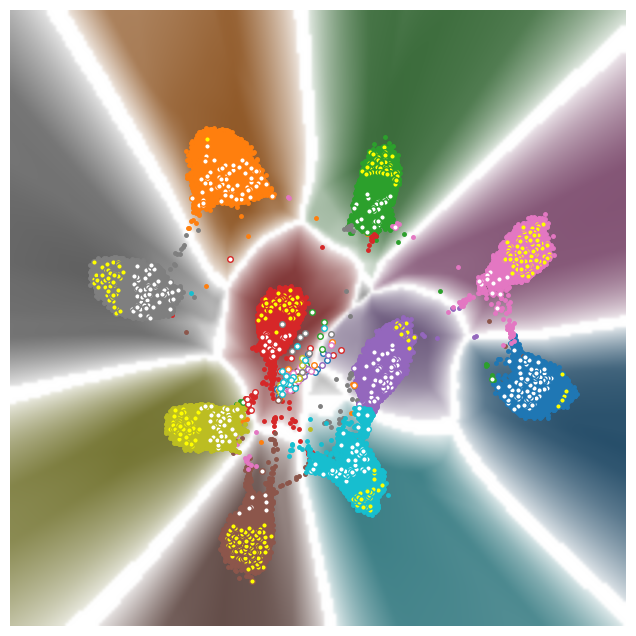

In [57]:
epoch = 10
save_dir = os.path.join(data_provider.model_path, "Epoch_{}".format(epoch))

def if_border(data):
    mesh_preds = data_provider.get_pred(epoch, data)
    mesh_preds = mesh_preds + 1e-8

    sort_preds = np.sort(mesh_preds, axis=1)
    diff = (sort_preds[:, -1] - sort_preds[:, -2]) / (sort_preds[:, -1] - sort_preds[:, 0])
    border = np.zeros(len(diff), dtype=np.uint8) + 0.05
    border[diff < 0.15] = 1
        
    return border
vis_model_name = 'trustvis_'
projector = DVIProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name=vis_model_name, device=DEVICE) 
from singleVis.skeVis import visualizer

vis = visualizer(data_provider, projector, 200, "tab10", "#fff")

####### get proxy ########
from trustVis.skeleton_generator import SkeletonGenerator
skeleton_generator = SkeletonGenerator(data_provider,epoch)

high_bom = skeleton_generator.skeleton_gen_use_perturb()
# print("shape",high_bom.shape )
centers = torch.randn(100, 512)
centers = centers = centers / centers.norm(dim=1, keepdim=True) * 1
centers = centers.cpu().detach().numpy()

high_bom = np.concatenate((high_bom, centers),axis = 0)
high_bom_c = high_bom[-550:] # open to see center
high_bom_b = high_bom[:550]# open to see border

high_bom = np.concatenate((high_bom_c, high_bom_b),axis = 0)

X = np.concatenate((high_bom, data_provider.train_representation(epoch)))
border = np.zeros(len(X))

border[:len(high_bom_c)] = 2

border[len(high_bom_c):len(high_bom_c) + len(high_bom_b)] = 1

border_elements_emd = projector.batch_project(epoch, X)


vis.show_grid_embedding(epoch=epoch, data=X, border=border, embedding=border_elements_emd, path=os.path.join(save_dir, "{}_{}_{}.png".format(DATASET, epoch, VIS_METHOD+'_grid')))

Successfully load the DVI visualization model for iteration 10
Computing decision regions ...
Successfully load the DVI visualization model for iteration 10
Successfully load the DVI visualization model for iteration 10
grid_samples (40000, 512)


100%|██████████| 300/300 [00:00<00:00, 7769.05it/s]


Successfully load the DVI visualization model for iteration 10


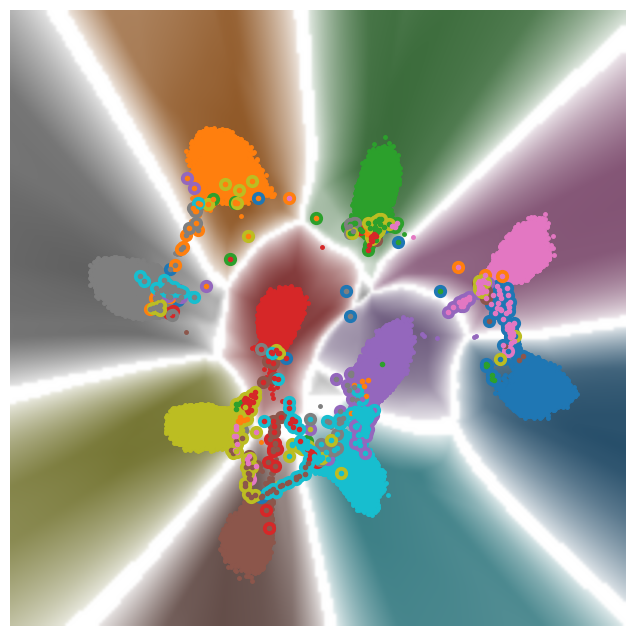

In [58]:
#### show training data
vis.savefig(epoch,path=os.path.join(save_dir, "{}_{}_{}.png".format(DATASET, epoch, 'dvigrid')))

In [26]:
projector = DVIProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name='dvi_ori', device=DEVICE)  
evaluator = Evaluator(data_provider, projector)

evaluator.eval_nn_train(epoch, 15)

Successfully load the DVI visualization model for iteration 10
Thu Aug  3 22:16:00 2023 Building RP forest with 17 trees
Thu Aug  3 22:16:00 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	Stopping threshold met -- exiting after 3 iterations
Thu Aug  3 22:16:02 2023 Building RP forest with 17 trees
Thu Aug  3 22:16:02 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	Stopping threshold met -- exiting after 2 iterations
#train# nn preserving: 2.28/15 in epoch 10


2.2796

In [59]:
from singleVis.eval.evaluator import Evaluator

projector = DVIProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name='trustvis_', device=DEVICE)  
evaluator = Evaluator(data_provider, projector)

evaluator.eval_nn_train(epoch, 15)

Successfully load the DVI visualization model for iteration 10
Thu Aug  3 23:15:06 2023 Building RP forest with 17 trees
Thu Aug  3 23:15:07 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	Stopping threshold met -- exiting after 3 iterations
Thu Aug  3 23:15:08 2023 Building RP forest with 17 trees
Thu Aug  3 23:15:09 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	Stopping threshold met -- exiting after 2 iterations
#train# nn preserving: 2.32/15 in epoch 10


2.3218

In [60]:
epoch = 10

def if_border(data):
    mesh_preds = data_provider.get_pred(epoch, data)
    mesh_preds = mesh_preds + 1e-8

    sort_preds = np.sort(mesh_preds, axis=1)
    diff = (sort_preds[:, -1] - sort_preds[:, -2]) / (sort_preds[:, -1] - sort_preds[:, 0])
    border = np.zeros(len(diff), dtype=np.uint8) + 0.05
    border[diff < 0.15] = 1
        
    return border
projector = DVIProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name='trustvis_', device=DEVICE)  
# projector = TimeVisProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name='vis', device=DEVICE)
training_emd = projector.batch_project(epoch, data_provider.train_representation(epoch))

training_new_data = projector.batch_inverse(epoch,training_emd )
pred =  data_provider.get_pred(epoch, data_provider.train_representation(epoch)).argmax(axis=1)
new_pred = data_provider.get_pred(epoch, training_new_data).argmax(axis=1)
k = 0
b = 0
old_border_list = if_border(data_provider.train_representation(epoch))
new_border_list = if_border(training_new_data)
for i in range(len(pred)):
    if pred[i] != new_pred[i]:
        k = k+1
        if old_border_list[i] == 1:
            b = b + 1

m = 0
for i in range(len(pred)):
    if old_border_list[i] != new_border_list[i]:
        m = m+1
print('vis error num:',k,'vis error on boundary: ', b ,'boundary flip:',m )

Successfully load the DVI visualization model for iteration 10
Successfully load the DVI visualization model for iteration 10


100%|██████████| 300/300 [00:00<00:00, 7817.03it/s]


vis error num: 179 vis error on boundary:  121 boundary flip: 286


In [48]:
epoch = 10

def if_border(data):
    mesh_preds = data_provider.get_pred(epoch, data)
    mesh_preds = mesh_preds + 1e-8

    sort_preds = np.sort(mesh_preds, axis=1)
    diff = (sort_preds[:, -1] - sort_preds[:, -2]) / (sort_preds[:, -1] - sort_preds[:, 0])
    border = np.zeros(len(diff), dtype=np.uint8) + 0.05
    border[diff < 0.15] = 1
        
    return border
projector = DVIProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name='best', device=DEVICE)  
# projector = TimeVisProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name='vis', device=DEVICE)
training_emd = projector.batch_project(epoch, data_provider.test_representation(epoch))

training_new_data = projector.batch_inverse(epoch,training_emd )
pred =  data_provider.get_pred(epoch, data_provider.test_representation(epoch)).argmax(axis=1)
new_pred = data_provider.get_pred(epoch, training_new_data).argmax(axis=1)
k = 0
b = 0
old_border_list = if_border(data_provider.test_representation(epoch))
new_border_list = if_border(training_new_data)
for i in range(len(pred)):
    if pred[i] != new_pred[i]:
        k = k+1
        if old_border_list[i] == 1:
            b = b + 1

m = 0
for i in range(len(pred)):
    if old_border_list[i] != new_border_list[i]:
        m = m+1
print('vis error num:',k,'vis error on boundary: ', b ,'boundary flip:',m )

Successfully load the DVI visualization model for iteration 10
Successfully load the DVI visualization model for iteration 10


100%|██████████| 50/50 [00:00<00:00, 13524.78it/s]

vis error num: 50 vis error on boundary:  28 boundary flip: 59
